# estimator classifier

## imports

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

## data

In [3]:
diabetes = pd.read_csv(
    "../../FULL-TENSORFLOW-NOTES-AND-DATA/Tensorflow-Bootcamp-master/02-TensorFlow-Basics/pima-indians-diabetes.csv"
)
diabetes.head(3)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,6,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,50,1,B
1,1,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,31,0,C
2,8,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,32,1,B


### cleaning
Here we'll preprocess the data.
#### normalization
Continuous numeric columns will be normalized below.

In [5]:
list(diabetes.columns)

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree',
 'Age',
 'Class',
 'Group']

In [13]:
cols_to_norm = list(diabetes.columns)[:-3]
cols_to_norm

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree']

In [7]:
diabetes[cols_to_norm] = diabetes[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
diabetes.head(3)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Class,Group
0,0.352941,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,50,1,B
1,0.058824,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,31,0,C
2,0.470588,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,32,1,B


## feature columns
### numeric

In [20]:
feat_cols_num = cols_to_norm[:]
feat_cols_num.append("Age")
feat_cols_num

['Number_pregnant',
 'Glucose_concentration',
 'Blood_pressure',
 'Triceps',
 'Insulin',
 'BMI',
 'Pedigree',
 'Age']

In [21]:
feat_cols_map = {}
for i in range(len(feat_cols_num)):
    key = feat_cols_num[i]
    feat_cols_map[key] = tf.feature_column.numeric_column(key)
feat_cols_map

{'Age': _NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'BMI': _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Blood_pressure': _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Glucose_concentration': _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Insulin': _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Number_pregnant': _NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Pedigree': _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 'Triceps': _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}

### categorical

In [29]:
sorted(diabetes["Group"].unique().tolist())

['A', 'B', 'C', 'D']

In [30]:
#vocab list implementation
assigned_group = tf.feature_column.categorical_column_with_vocabulary_list(
    "Group",
    sorted(diabetes["Group"].unique().tolist())
)

In [32]:
#hash bucket implementation
"""
assigned_group = tf.feature_column.categorical_column_with_hash_bucket(
    "Group",
    len(diabetes["Group"].unique().tolist())
)"""

'\nassigned_group = tf.feature_column.categorical_column_with_hash_bucket(\n    "Group",\n    len(diabetes["Group"].unique().tolist())\n)'

#### age
We'll convert age to a categorical column.

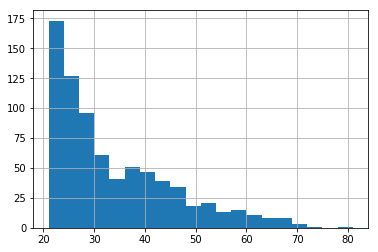

In [33]:
diabetes["Age"].hist(bins=20)

We'll break age up into buckets.

In [35]:
feat_cols_map["Age"] = tf.feature_column.bucketized_column(
    feat_cols_map["Age"],
    boundaries=[i for i in range(20, 90, 10)]
)

## something here

In [38]:
feat_cols = [feat_cols_map[k] for k in feat_cols_map]
feat_cols.append(assigned_group)
feat_cols

[_NumericColumn(key='Number_pregnant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Blood_pressure', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Triceps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Glucose_concentration', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Pedigree', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='Insulin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _BucketizedColumn(source_column=_NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(20, 30, 40, 50, 60, 70, 80)),
 _NumericColumn(key='BMI', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _HashedCategoricalColumn(key='Group', hash_bucket_size=4, dtype=tf.string)]

## splitting the data

In [41]:
x = diabetes.drop("Class", axis=1)
x.head(3)

,Number_pregnant,Glucose_concentration,Blood_pressure,Triceps,Insulin,BMI,Pedigree,Age,Group
0,0.352941,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,50,B
1,0.058824,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,31,C
2,0.470588,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,32,B


In [43]:
y = diabetes[["Class"]]
y.head(3)

,Class
0,1
1,0
2,1


In [44]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.3,
    random_state=101
)